In [1]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: wfuzz 3.1.0 has a non-standard dependency specifier pyparsing>=2.4*; python_version >= "3.5". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of wfuzz or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from ucimlrepo import fetch_ucirepo

In [3]:
mushroom = fetch_ucirepo(id=73)

x = mushroom.data.features[['gill-color', 'gill-size', 'ring-type']]
y = mushroom.data.targets

encoder = OneHotEncoder(sparse=False)
x_encoded = encoder.fit_transform(x)
y_encoded = encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=0.2, random_state=42)

C:\Users\marsh\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\marsh\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd

class Layer:
    def __init__(self, input_size, output_size):
        self.ws = 0.05
        self.x = None
        self.weights = None
        self.output_size = output_size
        if input_size is not None:
            self.weights = np.random.randn(input_size, output_size) * self.ws
        self.bias = np.zeros((1, output_size))

    def forward(self, x):
        if self.weights is None:
            input_size = x.shape[-1]
            self.weights = np.random.randn(input_size, self.output_size) * self.ws

        self.x = x
        output_data = np.dot(x, self.weights) + self.bias
        return output_data

    def backward(self, d_outputs, learning_rate):
        dx = np.dot(d_outputs, self.weights.T)
        dw = np.dot(self.x.T, d_outputs)
        db = np.sum(d_outputs, axis=0)
        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db
        return dx

In [3]:
class ReLU:
    def __init__(self):
        self.output_data = None

    def forward(self, input_data):
        self.output_data = np.maximum(0, input_data)
        return self.output_data

    def backward(self, d_output, learning_rate):
        return d_output * (self.output_data > 0)
    

In [4]:
class Softmax:
    def __init__(self):
        self.output_data = None

    def forward(self, input_data):
        exp_values = np.exp(input_data - np.max(input_data, axis=-1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=-1, keepdims=True)
        self.output_data = probabilities
        return self.output_data

    def backward(self, d_output, *params):
        batch_size = d_output.shape[0]
        dx = np.empty_like(d_output)

        for i in range(batch_size):
            softmax = self.output_data[i, :]
            jacobian_matrix = np.diag(softmax) - np.outer(softmax, softmax)
            dx[i] = np.dot(jacobian_matrix, d_output[i])

        return dx

In [5]:
from tqdm import tqdm

class NeuralNetwork:
    def __init__(self, layers, loss_fn):
        self.layers = layers
        self.loss = loss_fn

    def forward_propagation(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, d_output, learning_rate):
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate=learning_rate)

    def fit(self, X, y, learning_rate, epochs, batch_size=50):
        progress_bar = tqdm(total=epochs, desc="Training Progress")

        data_size = len(X)
        for epoch in range(epochs):
            indices = np.random.permutation(data_size)
            x_train_data_shuffled = X[indices]
            y_train_data_shuffled = y[indices]

            mean_loss_train = 0.0
            for batch_start in range(0, data_size, batch_size):
                batch_end = min(batch_start + batch_size, data_size)
                x_batch = x_train_data_shuffled[batch_start:batch_end]
                y_batch = y_train_data_shuffled[batch_start:batch_end]

                predictions_train = self.forward_propagation(x_batch)
                mean_loss_train += self.loss(y_batch, predictions_train)
                d_output_train = self.loss.backward(y_batch, predictions_train)
                self.backward(d_output_train, learning_rate)

            progress_bar.update(1)
            progress_bar.set_postfix({"Epoch": epoch + 1, "Train Mean Loss": f"{mean_loss_train / (data_size/batch_size):.4f}"})

    def predict(self, x):
        output = self.forward_propagation(x)
        return output

In [6]:
class LogLoss:
    def __call__(self, y_true, y_pred):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)

    def backward(self, y_true, y_pred):
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        return -y_true / (y_pred * len(y_true))

In [7]:
class MSE:
    def __call__(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def backward(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / len(y_true)




In [8]:
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, log_loss, mean_squared_error

# Классификация грибов 🍄🍄🍄😬😬😬

In [95]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]
layers = [
    Layer(input_size, 64),
    ReLU(),
    Layer(64, output_size),
    Softmax()
]

model = NeuralNetwork(layers, LogLoss())

model.fit(x_train, y_train, epochs=700, learning_rate=0.01)

Training Progress: 100%|████████████████████████| 700/700 [01:38<00:00,  7.09it/s, Train Loss=0.228]


In [100]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
print("F1 Score:", f1_score(true_classes, predicted_classes, average='weighted'))

F1 Score: 0.9242256781521986


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

class TorchModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.softmax(x)
        return x

input_size = x_train.shape[1]
output_size = y_train.shape[1]
model = TorchModel(input_size, output_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 700
with tqdm(total=epochs, desc="Training Progress", ncols=100) as pbar:
    for epoch in range(epochs):
        model.train()

        outputs = model(x_train_tensor)

        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'Train Loss': loss.item()})
        pbar.update(1)

def predict(model, x):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
    return outputs


Training Progress: 100%|████████████████████████| 700/700 [00:09<00:00, 75.32it/s, Train Loss=0.138]


In [88]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

predictions = predict(model, x_test_tensor)
predicted_classes = torch.argmax(predictions, dim=1).numpy()
true_classes = torch.argmax(y_test_tensor, dim=1).numpy()
print("F1 Score:", f1_score(true_classes, predicted_classes, average='weighted'))

F1 Score: 0.93414905103817


# Регрессия ноутбуков 💻💻💻

In [9]:
data = pd.read_csv("Laptop_price.csv")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Price'], axis = 1), data['Price'], test_size = 0.2, random_state = 42)
from category_encoders import TargetEncoder
enc = TargetEncoder(return_df = True).fit(X_train['Brand'],  y_train)
X_train['Brand'] = enc.transform(X_train['Brand'])
X_test['Brand'] = enc.transform(X_test['Brand'])

In [58]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

model = MLPRegressor(hidden_layer_sizes=(128), activation='relu', solver='adam', learning_rate='adaptive', learning_rate_init=0.01)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE on test data:", mse)

MSE on test data: 78916.26315788536


<Axes: >

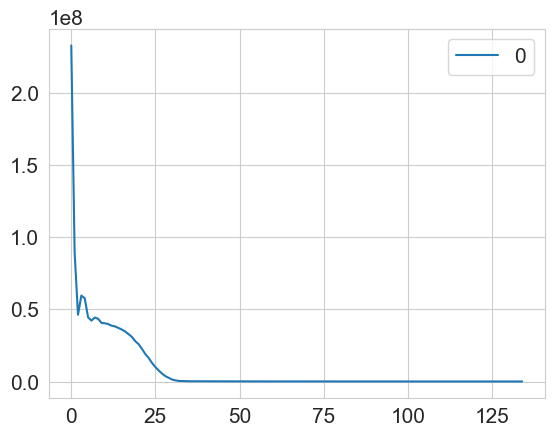

In [60]:
pd.DataFrame(model.loss_curve_).plot()

In [10]:
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
y_train, y_test = y_train.reshape((-1, 1)), y_test.reshape((-1, 1))

In [11]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
layers = [
    Layer(input_size, 128),
    ReLU(),
    Layer(128, 128),
    ReLU(),
    Layer(128, output_size),
]

model = NeuralNetwork(layers, MSE())

model.fit(X_train, y_train, learning_rate=0.01, epochs=1000, batch_size=50)

Training Progress: 100%|████████████████| 1000/1000 [00:40<00:00, 24.41it/s, Epoch=1000, Train Mean Loss=87806088.7659]
